**1. Imports and Setup**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)  # for reproducibility


**2. Create a Simple Sequence Dataset**

We’ll use the same logic as in FFNN:
10 random numbers → label = 1 if their sum > 5 else 0.

In [2]:
n_samples = 200
seq_len = 10
features = 1

X = torch.rand(n_samples, seq_len, features)
y = (X.sum(dim=1) > 5).float()  # 1 if sum>5 else 0

print("Example sequence:", X[0].squeeze().numpy())
print("Label:", y[0].item())

# Wrap into a dataset + dataloader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


Example sequence: [0.88226926 0.91500396 0.38286376 0.95930564 0.3904482  0.60089535
 0.25657248 0.7936413  0.94077146 0.13318592]
Label: 1.0


**3. Define a Simple RNN Model**

**RNN Layer**:

This is the core of the network — it reads the input step-by-step (one number at a time) and passes a hidden state forward at each step.

**Parameters:**

input_size=1 → each number is a single value.

hidden_size=8 → the RNN has 8 hidden neurons that act as memory.

batch_first=True → input shape is [batch, time, features] instead of [time, batch, features].


In [10]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True)


#After the RNN has read the entire sequence, it produces one final hidden vector summarizing what it remembered.
# This fully connected layer (Linear) converts that summary into a single value (a probability).
# Sigmoid makes sure the output is between 0 and 1.



        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, h_n = self.rnn(x)       # out: all hidden states, h_n: last hidden state
        last_out = out[:, -1, :]     # take last time step’s output
        return self.fc(last_out)     # Feed that last hidden state to the final layer to predict 0 or 1.


**4. Initialize Loss Function and Optimizer**

In [5]:
model = SimpleRNN()
criterion = nn.BCELoss()                    # binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)


**5. Training Loop with Loss History**

In [6]:
def train_model(model, loader, epochs=10):
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            preds = model(batch_x)              # (batch, 1)
            batch_y = batch_y.view(-1, 1)       # ensure (batch, 1)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    return loss_history

losses = train_model(model, loader, epochs=10)


Epoch 1 | Loss: 0.6910
Epoch 2 | Loss: 0.6617
Epoch 3 | Loss: 0.5366
Epoch 4 | Loss: 0.6790
Epoch 5 | Loss: 0.6409
Epoch 6 | Loss: 0.5213
Epoch 7 | Loss: 0.7225
Epoch 8 | Loss: 0.5851
Epoch 9 | Loss: 0.5333
Epoch 10 | Loss: 0.4616


**6. Visualize the Loss Curve**

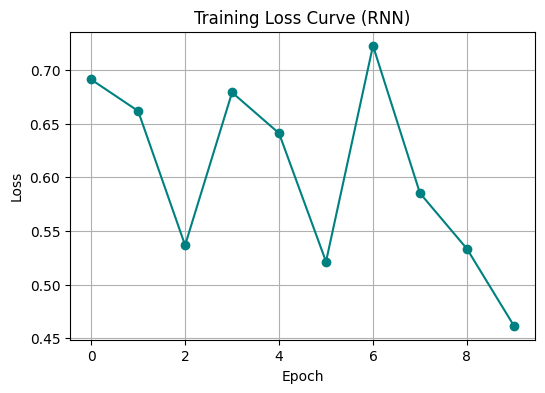

In [7]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker='o', color='teal')
plt.title("Training Loss Curve (RNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


**7. Check Model Predictions**

In [11]:
model.eval()
with torch.no_grad():
    sample = X[0].unsqueeze(0)
    pred = model(sample).item()
print(f"Predicted: {pred:.3f} | True Label: {y[0].item():.0f}")

Predicted: 0.847 | True Label: 1


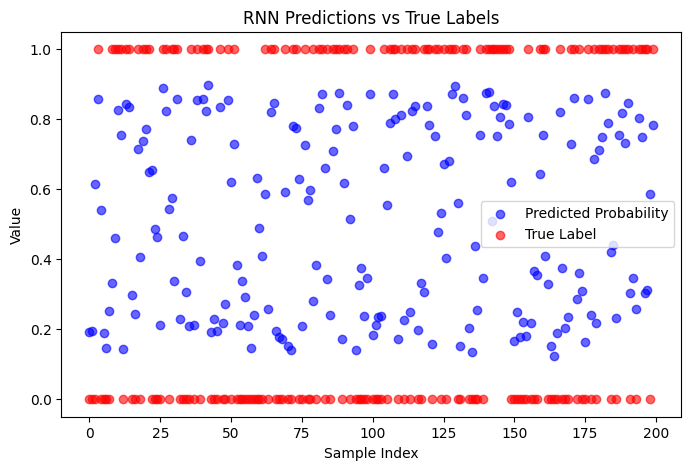

Model Accuracy: 50.02%


In [12]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(all_preds)), all_preds, color='blue', label='Predicted Probability', alpha=0.6)
plt.scatter(range(len(all_labels)), all_labels, color='red', label='True Label', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("RNN Predictions vs True Labels")
plt.legend()
plt.show()

# Quick accuracy check
pred_labels = (all_preds > 0.5).int()
accuracy = (pred_labels == all_labels.int()).float().mean().item()
print(f"Model Accuracy: {accuracy*100:.2f}%")
